In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import scipy
from scipy import stats
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.ticker import LinearLocator
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import joblib
import cartopy.crs as ccrs
import glob
import warnings
warnings.filterwarnings('ignore')
import xarray as xr

In [4]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 20})

In [5]:
### load best_estimator_ objects for observational models
reanalyses_models = joblib.load('./data/results/reanalyses_three_50models_each_60NS_finalNatGeo.pkl')

In [6]:
era5_models = reanalyses_models['era5']
merra_models = reanalyses_models['merra']
jra_models = reanalyses_models['jra']

In [7]:
era5_models

{'model_0': Ridge(alpha=1000, max_iter=1000, random_state=100),
 'model_1': Ridge(alpha=5000, max_iter=1000, random_state=100),
 'model_2': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_3': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_4': Ridge(alpha=5000, max_iter=1000, random_state=100),
 'model_5': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_6': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_7': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_8': Ridge(alpha=1000, max_iter=1000, random_state=100),
 'model_9': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_10': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_11': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_12': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_13': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_14': Ridge(alpha=3000, max_iter=1000, random_state=100),
 'model_15': Ridge(alpha=3000, max_

In [8]:
### we want to visualize the coefficients
era5_models['model_0'].coef_.shape

(25920,)

In [9]:
### nr realisations and loop over them to average coefficients
N=50
nr_lat = 24
nr_planes = 5
nr_lon = 72
lag=2
era5_coeffs_average = np.zeros((era5_models['model_0'].coef_.shape))
merra_coeffs_average = np.zeros((merra_models['model_0'].coef_.shape))
jra_coeffs_average = np.zeros((jra_models['model_0'].coef_.shape))
for i in range(0,N):
    era5_coeffs_average = era5_coeffs_average + era5_models['model_'+str(i)].coef_
    merra_coeffs_average = merra_coeffs_average + merra_models['model_'+str(i)].coef_
    jra_coeffs_average = jra_coeffs_average + jra_models['model_'+str(i)].coef_
era5_coeffs_average = era5_coeffs_average/float(N)
merra_coeffs_average = merra_coeffs_average/float(N)
jra_coeffs_average = jra_coeffs_average/float(N)
nr_coeffs_per_lag = nr_lat*nr_planes*nr_lon
era5_coeffs_average_lag0 = era5_coeffs_average[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
era5_coeffs_average_lag1 = era5_coeffs_average[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
era5_coeffs_average_lag2 = era5_coeffs_average[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
era5_coeffs_all = np.empty((lag+1,nr_planes,nr_lat,nr_lon))
era5_coeffs_all[0,:,:,:] = era5_coeffs_average_lag0
era5_coeffs_all[1,:,:,:] = era5_coeffs_average_lag1
era5_coeffs_all[2,:,:,:] = era5_coeffs_average_lag2

merra_coeffs_average_lag0 = merra_coeffs_average[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
merra_coeffs_average_lag1 = merra_coeffs_average[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
merra_coeffs_average_lag2 = merra_coeffs_average[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
merra_coeffs_all = np.empty((lag+1,nr_planes,nr_lat,nr_lon))
merra_coeffs_all[0,:,:,:] = merra_coeffs_average_lag0
merra_coeffs_all[1,:,:,:] = merra_coeffs_average_lag1
merra_coeffs_all[2,:,:,:] = merra_coeffs_average_lag2

jra_coeffs_average_lag0 = jra_coeffs_average[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
jra_coeffs_average_lag1 = jra_coeffs_average[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
jra_coeffs_average_lag2 = jra_coeffs_average[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
jra_coeffs_all = np.empty((lag+1,nr_planes,nr_lat,nr_lon))
jra_coeffs_all[0,:,:,:] = jra_coeffs_average_lag0
jra_coeffs_all[1,:,:,:] = jra_coeffs_average_lag1
jra_coeffs_all[2,:,:,:] = jra_coeffs_average_lag2

reanalysis_av_coeff = np.empty((lag+1,nr_planes,nr_lat,nr_lon))
reanalysis_av_coeff[0,:,:,:] = (era5_coeffs_average_lag0+merra_coeffs_average_lag0+jra_coeffs_average_lag0)/3.0
reanalysis_av_coeff[1,:,:,:] = (era5_coeffs_average_lag1+merra_coeffs_average_lag1+jra_coeffs_average_lag1)/3.0
reanalysis_av_coeff[2,:,:,:] = (era5_coeffs_average_lag2+merra_coeffs_average_lag0+jra_coeffs_average_lag2)/3.0

In [10]:
###latitude indices
la=6
lb=30
era_lat = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['lat'][la:lb]
era_lon = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['lon'][:]

In [11]:
### now load CMIP model ridge objects, including coeffs
results_dict_models = joblib.load('./data/results/models_lag2_5planes_60NS_all_models_final.pkl')

In [12]:
model_list_clean = ['ACCESS1-0',
 'ACCESS1-3',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CAMS-CSM1-0',
 'CanESM5',
 'CESM2_',
 'CESM2-WACCM',
 'FGOALS-f3-L',
 'GFDL-CM3',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MPI-ESM-LR',
 'MPI-ESM-MR',
 'MPI-ESM-P',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL']

In [13]:
nr_models = len(model_list_clean)
coeffs_cmip_mean = np.zeros(((lag+1)*nr_planes*nr_lat*nr_lon))
for modeli in range(0,nr_models):
    coeffs_cmip_mean = coeffs_cmip_mean + results_dict_models[model_list_clean[modeli]][0].best_estimator_.coef_
coeffs_cmip_mean = coeffs_cmip_mean/float(nr_models)

In [14]:
coeffs_cmip_mean_lag0 = coeffs_cmip_mean[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
coeffs_cmip_mean_lag1 = coeffs_cmip_mean[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
coeffs_cmip_mean_lag2 = coeffs_cmip_mean[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
coeffs_cmip_all = np.empty((lag+1,nr_planes,nr_lat,nr_lon))
coeffs_cmip_all[0,:,:,:] = coeffs_cmip_mean_lag0
coeffs_cmip_all[1,:,:,:] = coeffs_cmip_mean_lag1
coeffs_cmip_all[2,:,:,:] = coeffs_cmip_mean_lag2

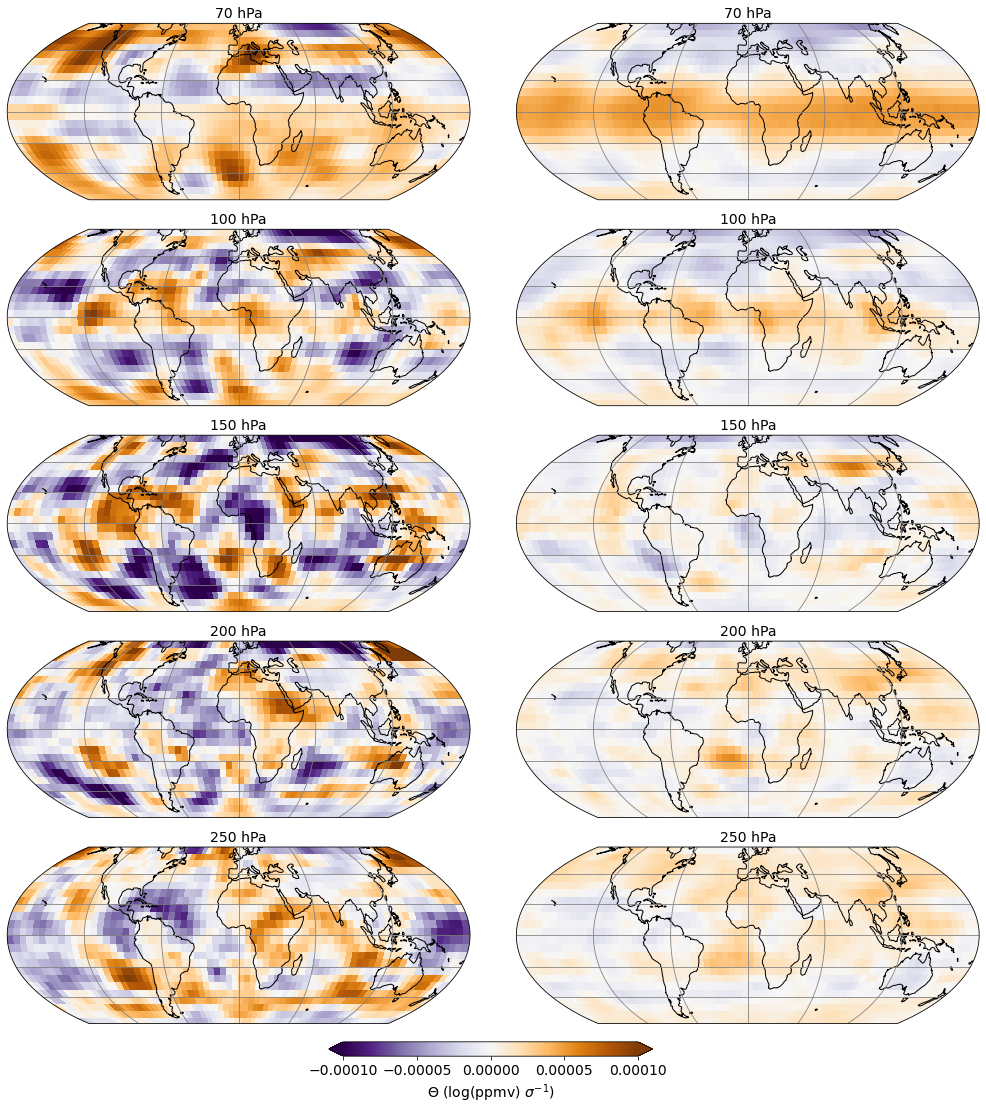

In [15]:
### compare for lag 0
### 
import matplotlib.patches
matplotlib.rcParams.update({'font.size': 14})
nrows=5
ncols=2
from cartopy.util import add_cyclic_point
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': ccrs.Mollweide()},figsize=(90,200))

plevels=['250 hPa', '200 hPa', '150 hPa', '100 hPa','70 hPa']
#Loop over all of the models
j=0
k=0
for i in [4,3,2,1,0]:
    data_cmip=coeffs_cmip_all[j,i,:,:]
    data_reanalyses=reanalysis_av_coeff[j,i,:,:]
# Add the cyclic point
    data_cmip,lons=add_cyclic_point(data_cmip,coord=era_lon)
    data_reanalyses,lons=add_cyclic_point(data_reanalyses,coord=era_lon)
# Contour plot
    cs=axs[k,0].pcolormesh(lons,era_lat,data_reanalyses,
                          transform = ccrs.PlateCarree(),
                          cmap='PuOr_r',vmin=-1e-4,vmax=1e-4)
    axs[k,0].set_title(plevels[i],fontsize=14)
# Draw the coastines for each subplot
    axs[k,0].coastlines()
    cs=axs[k,1].pcolormesh(lons,era_lat,data_cmip,
                          transform = ccrs.PlateCarree(),
                          cmap='PuOr_r',vmin=-1e-4,vmax=1e-4)
    axs[k,1].set_title(plevels[i],fontsize=14)
    axs[k,0].gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='gray')
    axs[k,1].gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='gray')
# Draw the coastines for each subplot
    axs[k,1].coastlines()
    k=k+1
fig.subplots_adjust(bottom=0.01, top=0.0815, left=0.1, right=0.25, wspace=0.1, hspace=0.0)

cbar_ax = fig.add_axes([0.1496, 0.00875, 0.05, 0.001])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')

fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
plt.savefig('../figures/coefficient_maps_cmip_reanalyses_comparison_5levels_lag0_PuOr_NatGeo_gridlines.pdf',bbox_inches='tight',dpi=175)

plt.show()

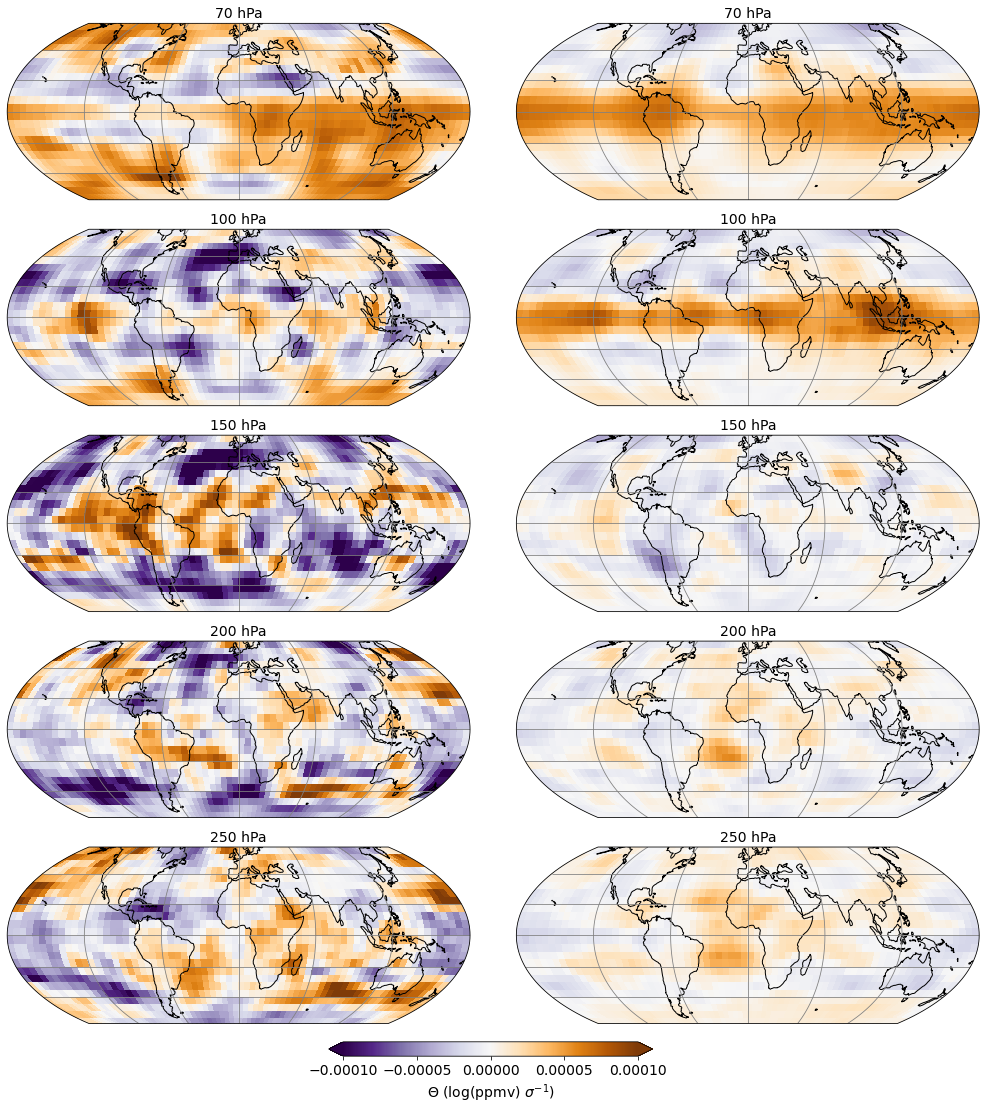

In [16]:
### compare for lag 1
### 
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': ccrs.Mollweide()},figsize=(90,200))
plevels=['250 hPa', '200 hPa', '150 hPa', '100 hPa','70 hPa']
#Loop over all of the models
# nt_point=126
j=1
k=0
for i in [4,3,2,1,0]:
#     for j in range(0,lag+1):
    data_cmip=coeffs_cmip_all[j,i,:,:]
    data_reanalyses=reanalysis_av_coeff[j,i,:,:]
# Add the cyclic point
    data_cmip,lons=add_cyclic_point(data_cmip,coord=era_lon)
    data_reanalyses,lons=add_cyclic_point(data_reanalyses,coord=era_lon)
# Contour plot
    cs=axs[k,0].pcolormesh(lons,era_lat,data_reanalyses,
                          transform = ccrs.PlateCarree(),
                          cmap='PuOr_r',vmin=-1e-4,vmax=1e-4)
    axs[k,0].set_title(plevels[i],fontsize=14)
# Draw the coastines for each subplot
    axs[k,0].coastlines()
    cs=axs[k,1].pcolormesh(lons,era_lat,data_cmip,
                          transform = ccrs.PlateCarree(),
                          cmap='PuOr_r',vmin=-1e-4,vmax=1e-4)
    axs[k,1].set_title(plevels[i],fontsize=14)
    axs[k,0].gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='gray')
    axs[k,1].gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='gray')
# Draw the coastines for each subplot
    axs[k,1].coastlines()
    k=k+1
fig.subplots_adjust(bottom=0.01, top=0.0815, left=0.1, right=0.25, wspace=0.1, hspace=0.0)

cbar_ax = fig.add_axes([0.1496, 0.00875, 0.05, 0.001])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')

fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
plt.savefig('../figures/coefficient_maps_cmip_reanalyses_comparison_5levels_lag1_PuOr_NatGeo_gridlines.pdf',bbox_inches='tight',dpi=175)

plt.show()

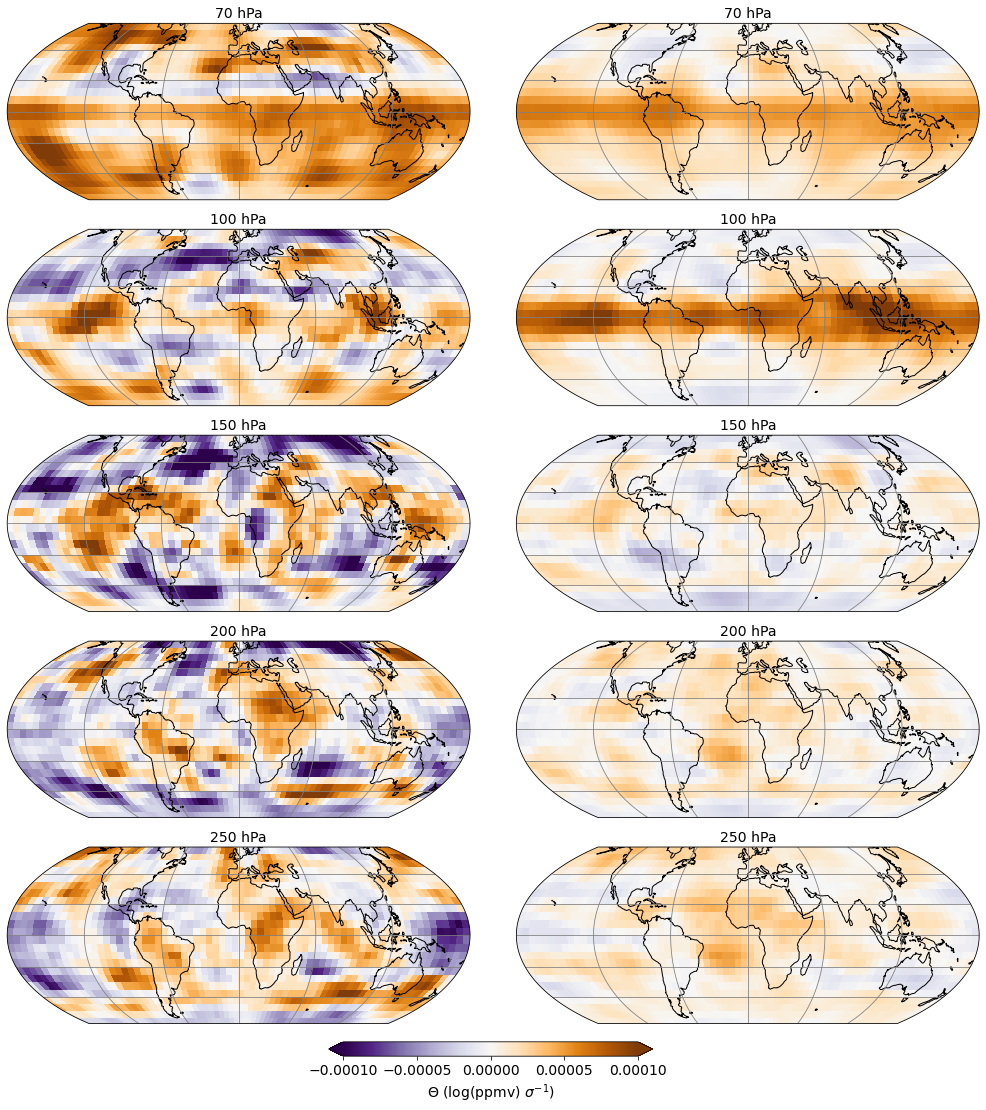

In [17]:
### compare for lag 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': ccrs.Mollweide()},figsize=(90,200))
j=2
k=0
for i in [4,3,2,1,0]:
    data_cmip=coeffs_cmip_all[j,i,:,:]
    data_reanalyses=reanalysis_av_coeff[j,i,:,:]
# Add the cyclic point
    data_cmip,lons=add_cyclic_point(data_cmip,coord=era_lon)
    data_reanalyses,lons=add_cyclic_point(data_reanalyses,coord=era_lon)
# Contour plot
    cs=axs[k,0].pcolormesh(lons,era_lat,data_reanalyses,
                          transform = ccrs.PlateCarree(),
                          cmap='PuOr_r',vmin=-1e-4,vmax=1e-4)
    axs[k,0].set_title(plevels[i],fontsize=14)
# Draw the coastines for each subplot
    axs[k,0].coastlines()
    cs=axs[k,1].pcolormesh(lons,era_lat,data_cmip,
                          transform = ccrs.PlateCarree(),
                          cmap='PuOr_r',vmin=-1e-4,vmax=1e-4)
    axs[k,1].set_title(plevels[i],fontsize=14)
    axs[k,0].gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='gray')
    axs[k,1].gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='gray')
# Draw the coastines for each subplot
    axs[k,1].coastlines()
    k=k+1
fig.subplots_adjust(bottom=0.01, top=0.0815, left=0.1, right=0.25, wspace=0.1, hspace=0.0)

cbar_ax = fig.add_axes([0.1496, 0.00875, 0.05, 0.001])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')

fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
plt.savefig('./figures/coefficient_maps_cmip_reanalyses_comparison_5levels_lag2_PuOr_NatGeo_gridlines.pdf',bbox_inches='tight',dpi=175)

plt.show()

In [18]:
###now move on to vertical lat-height cross-sections
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

In [19]:
print(reanalysis_av_coeff.shape)
print(coeffs_cmip_all.shape)
reanalysis_av_coeff_zm = np.mean(reanalysis_av_coeff,axis=3)
coeffs_cmip_all_zm = np.mean(coeffs_cmip_all,axis=3)
plevels = np.array([250.0,200.0,150.0,100.0,70.0])
logp = np.log(plevels)

(3, 5, 24, 72)
(3, 5, 24, 72)


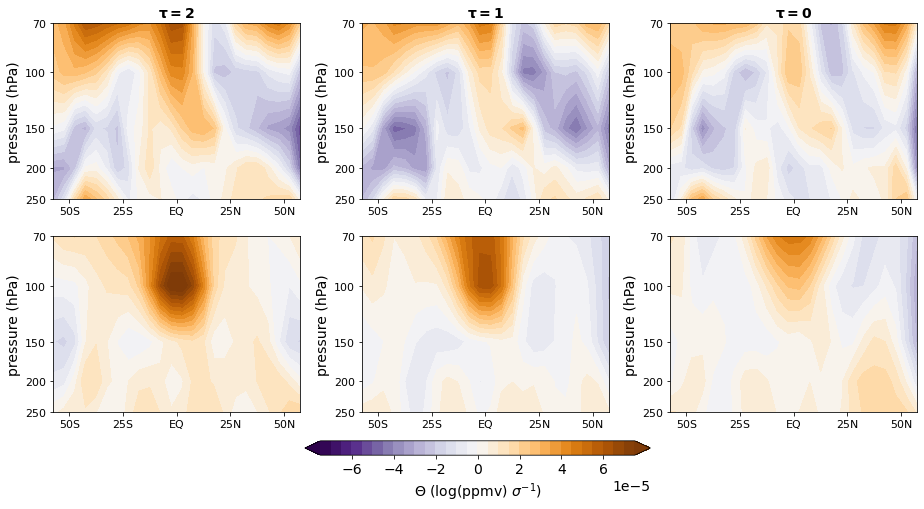

In [20]:
### Figure 4c
nrows=2
ncols=3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(60,40))
levs = np.linspace(-7.5e-5,7.5e-5,31)
plevels_labels=['250', '200', '150', '100','70']
j=0
for i in [2,1,0]:
    data_cmip=coeffs_cmip_all_zm[i,:,:]
    data_reanalyses=reanalysis_av_coeff_zm[i,:,:]
    cs=axs[0,j].contourf(era_lat,-logp,data_reanalyses,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[0,j].set_yticks(-logp)
    axs[0,j].set_yticklabels(plevels_labels,size=11)
    axs[0,j].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[0,j].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[0,j].set_ylabel('pressure (hPa)',size=14)
    axs[0,j].set_title(r'$\mathbf{\tau=}$'+str(i),fontsize=14,fontweight='bold')
    cs=axs[1,j].contourf(era_lat,-logp,data_cmip,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[1,j].set_yticks(-logp)
    axs[1,j].set_yticklabels(plevels_labels,size=11)
    axs[1,j].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[1,j].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[1,j].set_ylabel('pressure (hPa)',size=14)
    j=j+1

fig.subplots_adjust(bottom=0.015, top=0.15, left=0.05, right=0.25, wspace=0.25, hspace=0.215)

cbar_ax = fig.add_axes([0.10825, 0.00, 0.08, 0.005])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both',pad=0.75)
fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
# plt.savefig('./figures/zonal_mean_reanalyses_and_CMIP_PuOr_final_NatGeo.pdf',bbox_inches='tight',dpi=175)
# plt.savefig('./figures/zonal_mean_reanalyses_and_CMIP_PuOr_final_NatGeo.png',bbox_inches='tight',dpi=175)

plt.show()

In [23]:
model_list_labels = ['ACCESS1-0',
 'ACCESS1-3',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CAMS-CSM1-0',
 'CanESM5',
 'CESM2',
 'CESM2-WACCM',
 'FGOALS-f3-L',
 'GFDL-CM3',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MPI-ESM-LR',
 'MPI-ESM-MR',
 'MPI-ESM-P',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL']

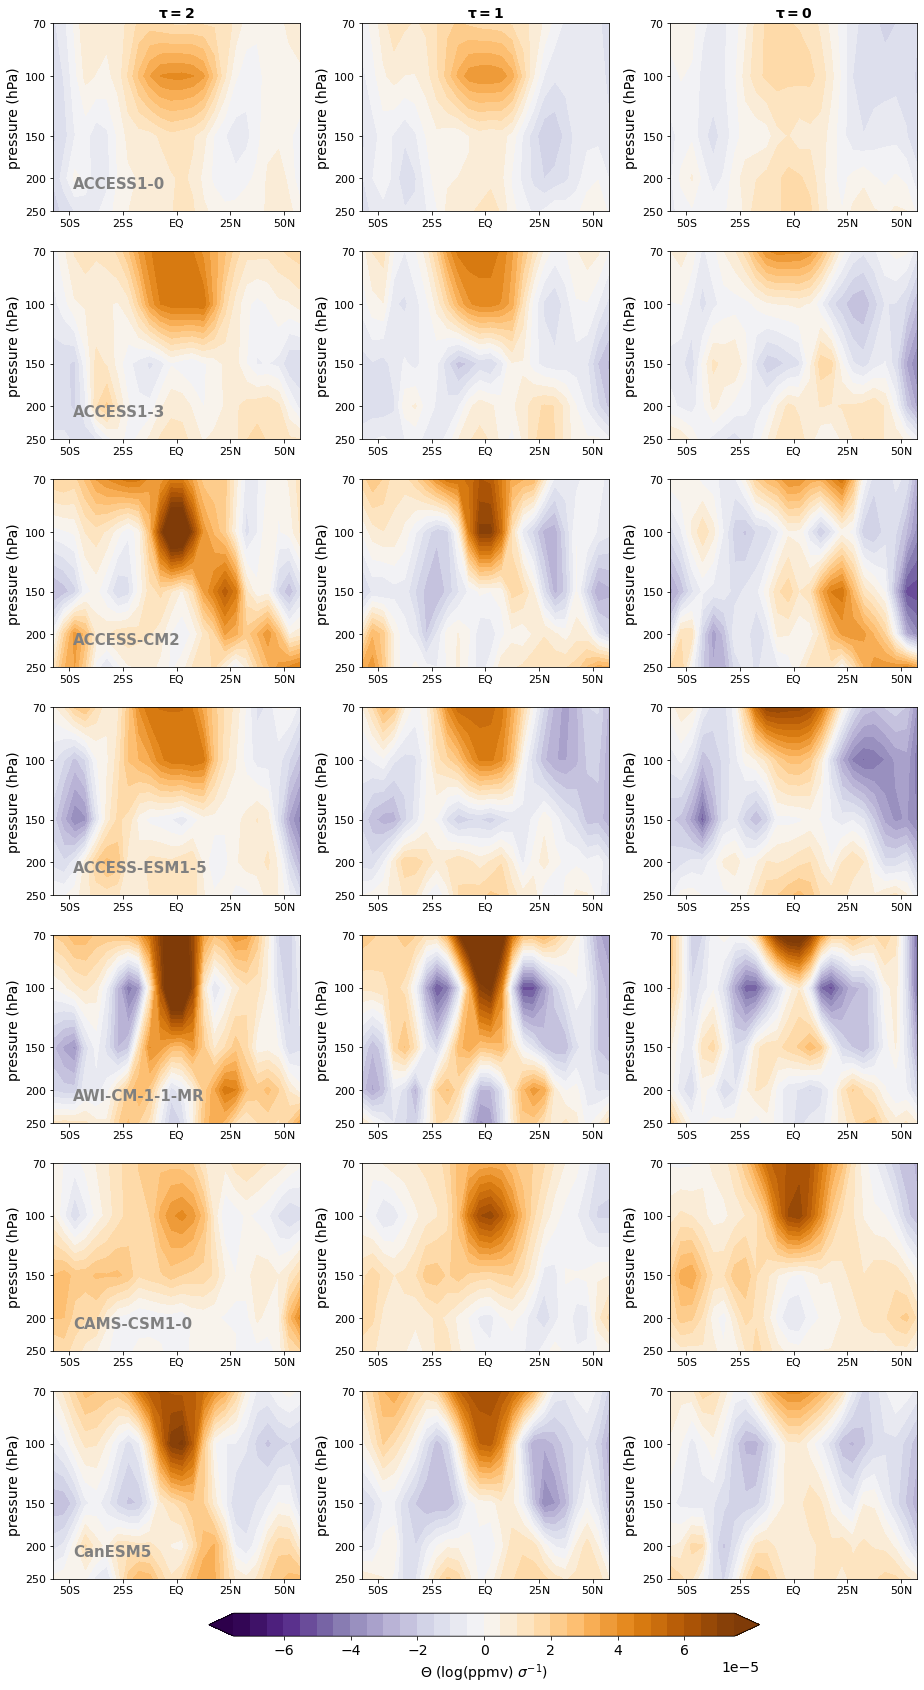

In [24]:
### Supplementary Figure 12
nrows=7
ncols=3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(60,160))
levs = np.linspace(-7.5e-5,7.5e-5,31)
plevels_labels=['250', '200', '150', '100','70']
j=0
for modeli in range(0,7):
    coeffs_cmip = results_dict_models[model_list_clean[modeli]][0].best_estimator_.coef_
    coeffs_cmip_lag0 = coeffs_cmip[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag1 = coeffs_cmip[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag2 = coeffs_cmip[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag0_zm = np.mean(coeffs_cmip_lag0,axis=2)
    coeffs_cmip_lag1_zm = np.mean(coeffs_cmip_lag1,axis=2)
    coeffs_cmip_lag2_zm = np.mean(coeffs_cmip_lag2,axis=2)
    cs=axs[modeli,0].contourf(era_lat,-logp,coeffs_cmip_lag2_zm,levels=levs,
                          cmap='PuOr_r',extend='both')#,vmin=-5e-5,vmax=5e-5)
    axs[modeli,0].set_yticks(-logp)
    axs[modeli,0].set_yticklabels(plevels_labels,size=11)
    axs[modeli,0].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,0].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,0].set_ylabel('pressure (hPa)',size=14)
    axs[modeli,0].text(0.08,0.12,model_list_labels[modeli],fontweight='bold',fontsize=15,color='gray',transform=axs[modeli,0].transAxes)
    if modeli==0:
        axs[modeli,0].set_title(r'$\mathbf{\tau=}$'+str(2),fontsize=14,fontweight='bold')

    cs=axs[modeli,1].contourf(era_lat,-logp,coeffs_cmip_lag1_zm,levels=levs,
                          cmap='PuOr_r',extend='both')#,vmin=-5e-5,vmax=5e-5)
    axs[modeli,1].set_yticks(-logp)
    axs[modeli,1].set_yticklabels(plevels_labels,size=11)
    axs[modeli,1].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,1].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,1].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,1].set_title(r'$\mathbf{\tau=}$'+str(1),fontsize=14,fontweight='bold')
    
    cs=axs[modeli,2].contourf(era_lat,-logp,coeffs_cmip_lag0_zm,levels=levs,
                          cmap='PuOr_r',extend='both')#,vmin=-5e-5,vmax=5e-5)
    axs[modeli,2].set_yticks(-logp)
    axs[modeli,2].set_yticklabels(plevels_labels,size=11)
    axs[modeli,2].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,2].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,2].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,2].set_title(r'$\mathbf{\tau=}$'+str(0),fontsize=14,fontweight='bold')

fig.subplots_adjust(bottom=0.015, top=0.15, left=0.05, right=0.25, wspace=0.25, hspace=0.215)

cbar_ax = fig.add_axes([0.086, 0.01, 0.1275, 0.002])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')
plt.show()

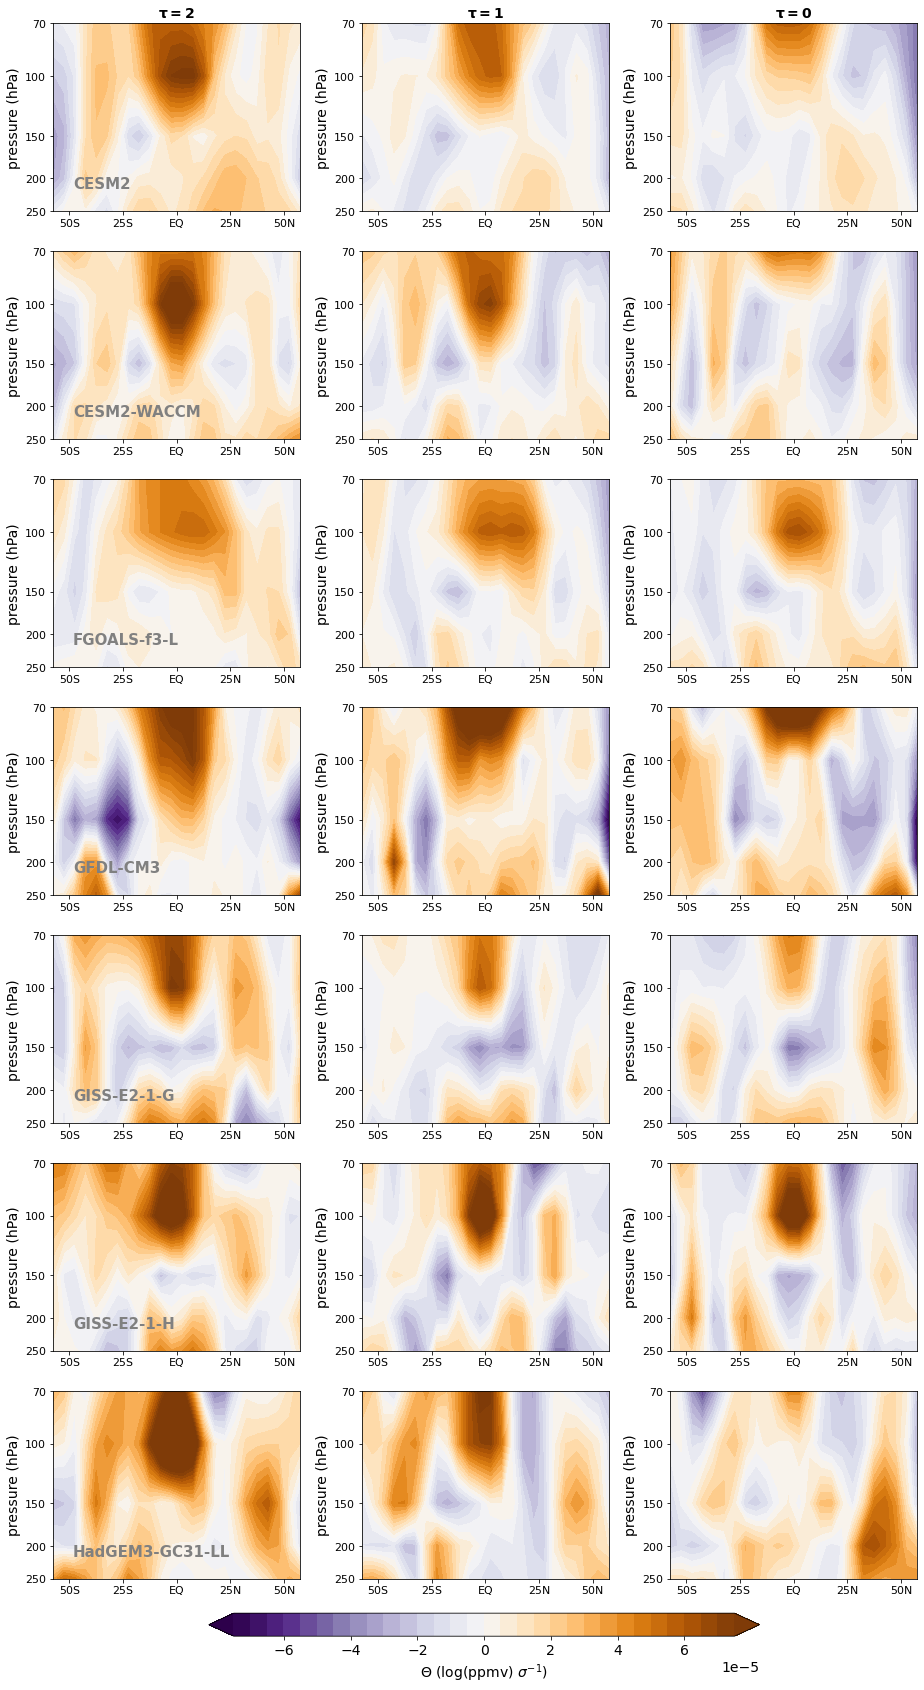

In [25]:
### Supplementary Figure 13
nrows=7
ncols=3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(60,160))
levs = np.linspace(-7.5e-5,7.5e-5,31)
j=0
for modeli in range(0,7):
    coeffs_cmip = results_dict_models[model_list_clean[modeli+7]][0].best_estimator_.coef_
    coeffs_cmip_lag0 = coeffs_cmip[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag1 = coeffs_cmip[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag2 = coeffs_cmip[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag0_zm = np.mean(coeffs_cmip_lag0,axis=2)
    coeffs_cmip_lag1_zm = np.mean(coeffs_cmip_lag1,axis=2)
    coeffs_cmip_lag2_zm = np.mean(coeffs_cmip_lag2,axis=2)
    cs=axs[modeli,0].contourf(era_lat,-logp,coeffs_cmip_lag2_zm,levels=levs,
                          cmap='PuOr_r',extend='both')#,vmin=-5e-5,vmax=5e-5)
    axs[modeli,0].set_yticks(-logp)
    axs[modeli,0].set_yticklabels(plevels_labels,size=11)
    axs[modeli,0].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,0].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,0].set_ylabel('pressure (hPa)',size=14)
    axs[modeli,0].text(0.08,0.12,model_list_labels[modeli+7],fontweight='bold',fontsize=15,color='gray',transform=axs[modeli,0].transAxes)
    if modeli==0:
        axs[modeli,0].set_title(r'$\mathbf{\tau=}$'+str(2),fontsize=14,fontweight='bold')

    cs=axs[modeli,1].contourf(era_lat,-logp,coeffs_cmip_lag1_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,1].set_yticks(-logp)
    axs[modeli,1].set_yticklabels(plevels_labels,size=11)
    axs[modeli,1].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,1].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,1].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,1].set_title(r'$\mathbf{\tau=}$'+str(1),fontsize=14,fontweight='bold')
    
    cs=axs[modeli,2].contourf(era_lat,-logp,coeffs_cmip_lag0_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,2].set_yticks(-logp)
    axs[modeli,2].set_yticklabels(plevels_labels,size=11)
    axs[modeli,2].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,2].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,2].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,2].set_title(r'$\mathbf{\tau=}$'+str(0),fontsize=14,fontweight='bold')
fig.subplots_adjust(bottom=0.015, top=0.15, left=0.05, right=0.25, wspace=0.25, hspace=0.215)
cbar_ax = fig.add_axes([0.086, 0.01, 0.1275, 0.002])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')
fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
plt.show()

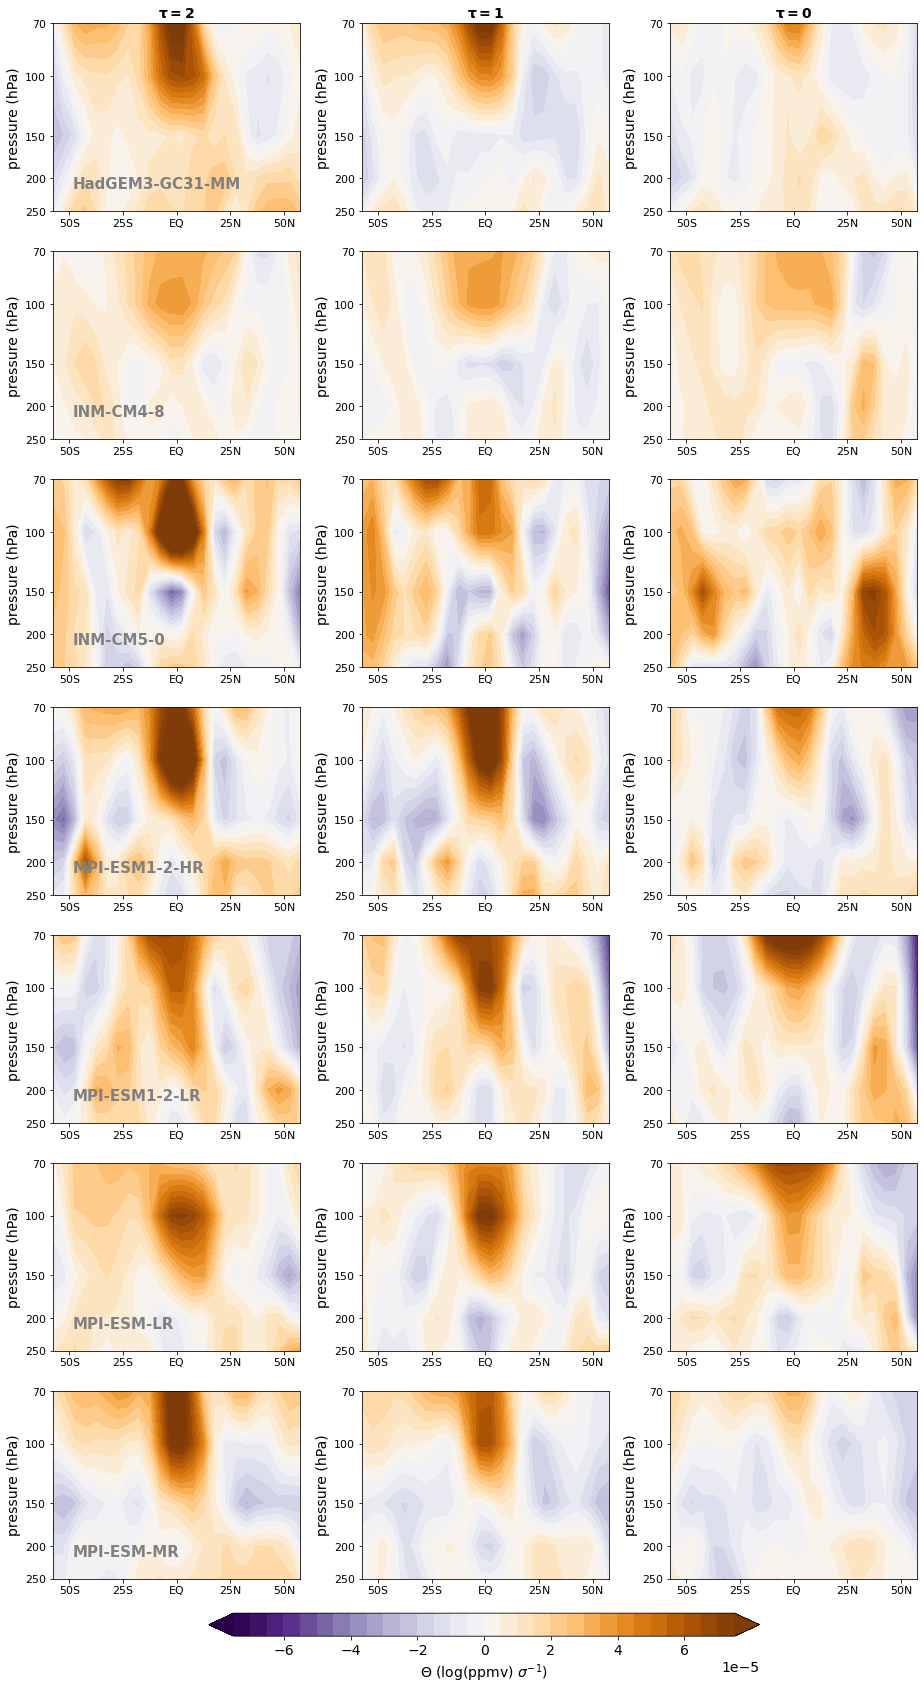

In [26]:
### Supplementary Figure 14
nrows=7
ncols=3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(60,160))
levs = np.linspace(-7.5e-5,7.5e-5,31)
j=0
for modeli in range(0,7):
    coeffs_cmip = results_dict_models[model_list_clean[modeli+14]][0].best_estimator_.coef_
    coeffs_cmip_lag0 = coeffs_cmip[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag1 = coeffs_cmip[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag2 = coeffs_cmip[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag0_zm = np.mean(coeffs_cmip_lag0,axis=2)
    coeffs_cmip_lag1_zm = np.mean(coeffs_cmip_lag1,axis=2)
    coeffs_cmip_lag2_zm = np.mean(coeffs_cmip_lag2,axis=2)
    cs=axs[modeli,0].contourf(era_lat,-logp,coeffs_cmip_lag2_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,0].set_yticks(-logp)
    axs[modeli,0].set_yticklabels(plevels_labels,size=11)
    axs[modeli,0].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,0].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,0].set_ylabel('pressure (hPa)',size=14)
    axs[modeli,0].text(0.08,0.12,model_list_labels[modeli+14],fontweight='bold',fontsize=15,color='gray',transform=axs[modeli,0].transAxes)
    if modeli==0:
        axs[modeli,0].set_title(r'$\mathbf{\tau=}$'+str(2),fontsize=14,fontweight='bold')

    cs=axs[modeli,1].contourf(era_lat,-logp,coeffs_cmip_lag1_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,1].set_yticks(-logp)
    axs[modeli,1].set_yticklabels(plevels_labels,size=11)
    axs[modeli,1].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,1].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,1].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,1].set_title(r'$\mathbf{\tau=}$'+str(1),fontsize=14,fontweight='bold')
    
    cs=axs[modeli,2].contourf(era_lat,-logp,coeffs_cmip_lag0_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,2].set_yticks(-logp)
    axs[modeli,2].set_yticklabels(plevels_labels,size=11)
    axs[modeli,2].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,2].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,2].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,2].set_title(r'$\mathbf{\tau=}$'+str(0),fontsize=14,fontweight='bold')
fig.subplots_adjust(bottom=0.015, top=0.15, left=0.05, right=0.25, wspace=0.25, hspace=0.215)
cbar_ax = fig.add_axes([0.086, 0.01, 0.1275, 0.002])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')
fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
plt.show()

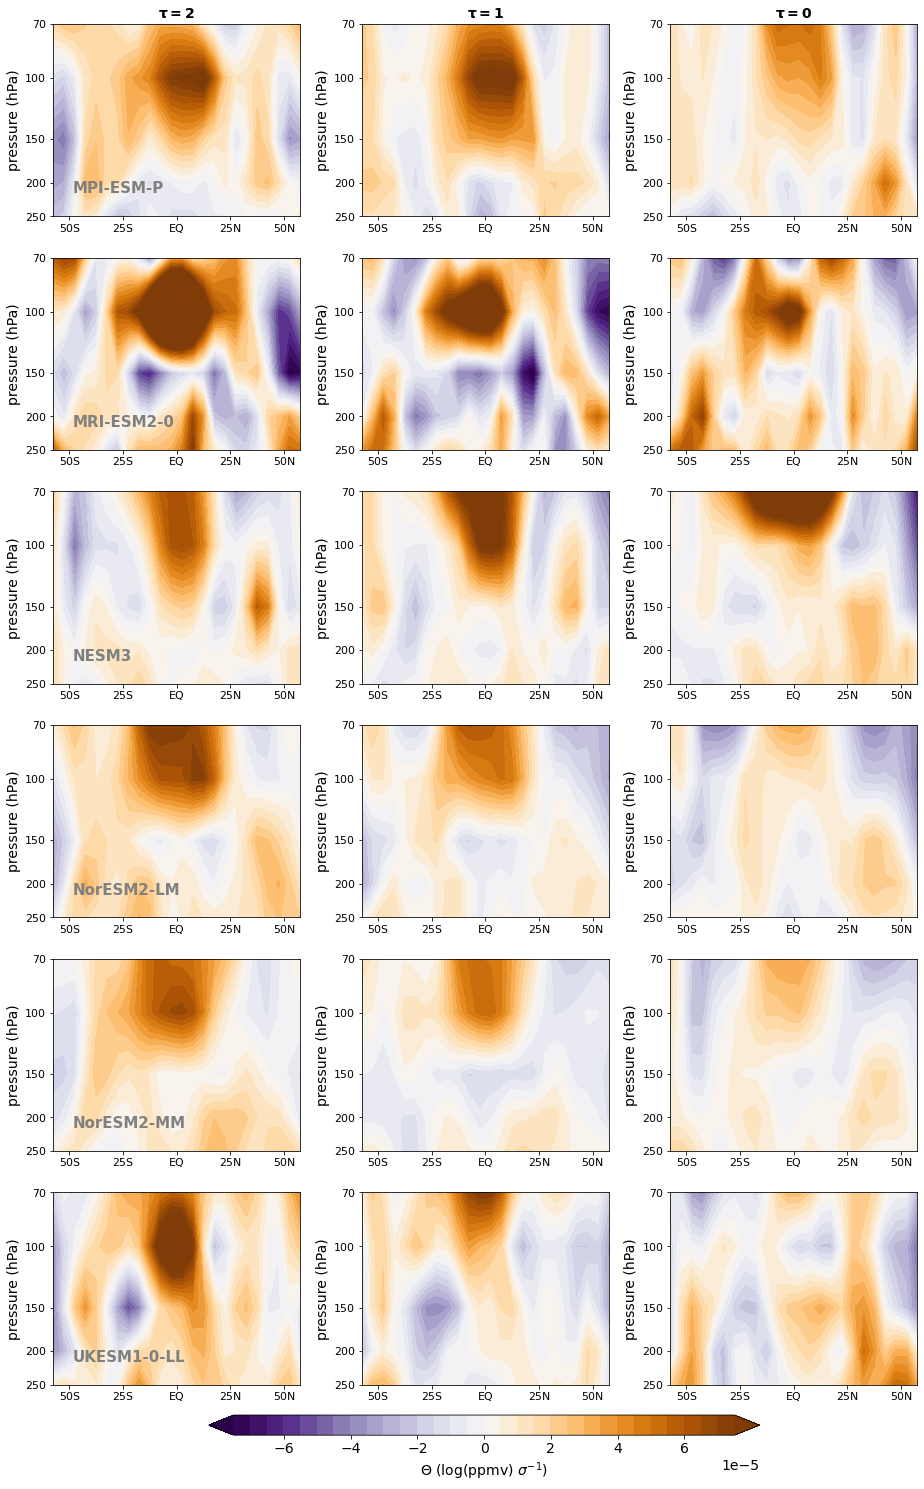

In [27]:
### Supplementary Figure 15
nrows=6
ncols=3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(60,140))
levs = np.linspace(-7.5e-5,7.5e-5,31)
j=0
for modeli in range(0,6):
    coeffs_cmip = results_dict_models[model_list_clean[modeli+21]][0].best_estimator_.coef_
    coeffs_cmip_lag0 = coeffs_cmip[0:nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag1 = coeffs_cmip[nr_coeffs_per_lag:2*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag2 = coeffs_cmip[nr_coeffs_per_lag*2:3*nr_coeffs_per_lag].reshape(nr_planes,nr_lat,nr_lon)
    coeffs_cmip_lag0_zm = np.mean(coeffs_cmip_lag0,axis=2)
    coeffs_cmip_lag1_zm = np.mean(coeffs_cmip_lag1,axis=2)
    coeffs_cmip_lag2_zm = np.mean(coeffs_cmip_lag2,axis=2)
    cs=axs[modeli,0].contourf(era_lat,-logp,coeffs_cmip_lag2_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,0].set_yticks(-logp)
    axs[modeli,0].set_yticklabels(plevels_labels,size=11)
    axs[modeli,0].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,0].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,0].set_ylabel('pressure (hPa)',size=14)
    axs[modeli,0].text(0.08,0.12,model_list_labels[modeli+21],fontweight='bold',fontsize=15,color='gray',transform=axs[modeli,0].transAxes)
    if modeli==0:
        axs[modeli,0].set_title(r'$\mathbf{\tau=}$'+str(2),fontsize=14,fontweight='bold')

    cs=axs[modeli,1].contourf(era_lat,-logp,coeffs_cmip_lag1_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,1].set_yticks(-logp)
    axs[modeli,1].set_yticklabels(plevels_labels,size=11)
    axs[modeli,1].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,1].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,1].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,1].set_title(r'$\mathbf{\tau=}$'+str(1),fontsize=14,fontweight='bold')
    
    cs=axs[modeli,2].contourf(era_lat,-logp,coeffs_cmip_lag0_zm,levels=levs,
                          cmap='PuOr_r',extend='both')
    axs[modeli,2].set_yticks(-logp)
    axs[modeli,2].set_yticklabels(plevels_labels,size=11)
    axs[modeli,2].set_xticks([-50.0,-25.0,0,25.0,50.0])
    axs[modeli,2].set_xticklabels(['50S','25S','EQ','25N','50N'],size=11)
    axs[modeli,2].set_ylabel('pressure (hPa)',size=14)
    if modeli==0:
        axs[modeli,2].set_title(r'$\mathbf{\tau=}$'+str(0),fontsize=14,fontweight='bold')
fig.subplots_adjust(bottom=0.015, top=0.15, left=0.05, right=0.25, wspace=0.25, hspace=0.215)

cbar_ax = fig.add_axes([0.086, 0.01, 0.1275, 0.002])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$\Theta$ (log(ppmv) $\sigma^{-1}$)',extend='both')
fig.tight_layout(rect=[0.025, 1.0, 1.0, 1.0])
plt.show()